In [2]:
%reset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## 数据处理

In [3]:
bchain = pd.read_csv('BCHAIN-MKPRU.csv')
lbma = pd.read_csv('LBMA-GOLD.csv')

In [ ]:
pd.D

In [4]:
lbma['Date'] = lbma['Date'].astype('datetime64')
bchain['Date'] = bchain['Date'].astype('datetime64')

In [5]:
lbma['Date'] = pd.to_datetime(lbma['Date'], format='%Y-%m-%d')
bchain['Date'] = pd.to_datetime(bchain['Date'], format='%Y-%m-%d')

In [6]:
# 转换格式 
bchain.to_csv('bchain.csv', index=0)
lbma.to_csv('lbma.csv', index=0)

In [7]:
bchain = pd.read_csv('bchain.csv')
lbma = pd.read_csv('lbma.csv')

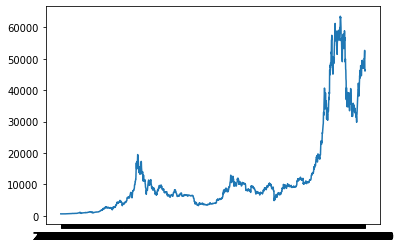

In [9]:
plt.plot(bchain['Date'], bchain['Value'])

In [10]:
bchain.values

array([['2016-09-11', 621.65],
       ['2016-09-12', 609.67],
       ['2016-09-13', 610.92],
       ...,
       ['2021-09-08', 46809.17],
       ['2021-09-09', 46078.38],
       ['2021-09-10', 46368.69]], dtype=object)

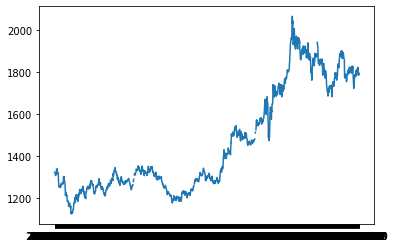

In [11]:
plt.plot(lbma['Date'], lbma['USD (PM)'])

In [12]:
# 删除缺失值
lbma.drop(lbma[lbma['USD (PM)'].isnull()].index,inplace=True)

In [13]:
# 合成一张表 黄金缺失补前一天的
USD = []
before = lbma.iloc[0,1]
for i in bchain.Date:
    try:
        before = lbma[lbma.Date == i].iloc[0,1]
        USD.append(before)
    except:
        USD.append(before)

In [14]:
all_value = pd.concat([bchain,pd.Series(USD,name = 'USD_PM')],axis=1)

In [15]:
all_value.to_csv('all_value.csv',index=0)

In [16]:
all_value = pd.read_csv('all_value.csv')

## 正态检验

$Ln\frac{P_{i+1}}{P_{i}}$ 服从正态

In [17]:
# 比特币
log_return = np.log(lbma.iloc[:,1]/lbma.iloc[:,1].shift(1)).dropna()

In [19]:
log_return
# 比特币每日交易5年 每年365天

1      -0.000717
2      -0.001436
3      -0.008319
4      -0.001871
5       0.004956
          ...   
1260   -0.001152
1261   -0.010735
1262   -0.009002
1263    0.001259
1264    0.003545
Name: USD (PM), Length: 1254, dtype: float64

In [9]:
lbma.shape
# 黄金交易251天

(1255, 2)

In [10]:
from scipy import stats

E:\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


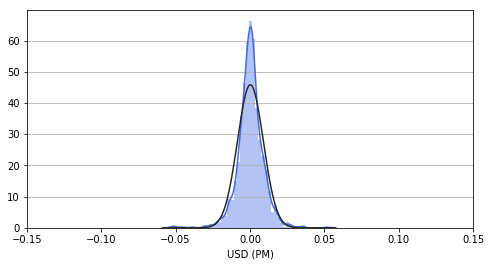

In [15]:
fig, ax1 = plt.subplots(figsize=(8,4))
# sns.distplot(returns, norm_hist=True, fit=stats.norm, color='blue',
#              bins=50, ax=ax1)
# ax1.set_title('Returns')
sns.distplot(log_return, norm_hist=True, fit=stats.norm, color='royalblue',
             bins=50)
ax1.set_xlim(left=-0.15,right=0.15)
plt.grid(axis='y')
fig.savefig('Norm.svg',bbox_inches="tight")

In [17]:
# x = np.random.normal(0,1,1000)
# stats.kstest(x, 'norm')
# p值太小其实并不正态
stats.kstest(log_return,'norm')

KstestResult(statistic=0.48523057216759713, pvalue=0.0)

**Analysis:** slight negative skewness
positive kurtosis (leptokurtic) - higher peak with thick tails than the standard normal distribution.
轻微的阴性偏斜，基本正态分布

In [18]:
# 计算黄金
lbm_return = np.log(lbma['USD (PM)']/lbma['USD (PM)'].shift(1)).dropna()

# 指标具体

**各自历史波动率**

In [28]:
import talib

In [24]:
def HV(df,t,year_day=251):
    trade_date=pd.DataFrame(dtype=np.float64)
    for i in range(t,len(df.index)):#计算20天的波动率
        trade_date[i]=np.std(np.log(df[i-t:i] /df[i-t:i].shift(-1)))*np.sqrt(year_day)*100#波动率计算
    return trade_date.values

In [25]:
b_HV_7 = HV(bchain.iloc[:,[0,1]].set_index('Date'),7,365)

In [27]:
l_HV_7 = HV(lbma.iloc[:,[0,1]].set_index('Date'),7,251)

**10日均线**

In [ ]:
bchain['10_mean'] = talib.SMA(bchain.iloc[:,1].values,timeperiod=10)
lbma['10_mean'] = talib.SMA(lbma.iloc[:,1].values,timeperiod=10)
# bchain.to_csv('bchain_10mean.csv',index=0)
# lbma.to_csv('lbma_10mean.csv',index=0)

**MACD**

In [29]:
# MACD
macd, signel, macdhist = talib.MACD(bchain['Value'].values, fastperiod=12, slowperiod=26, signalperiod=9)

In [30]:
c = []
for i in macdhist:
    if i > 0:
        c.append('g')
    else:
        c.append('r')

In [31]:
import matplotlib.ticker as ticker

In [35]:
import matplotlib.dates as mdate

In [37]:
bchain.dtypes

Date      object
Value    float64
dtype: object

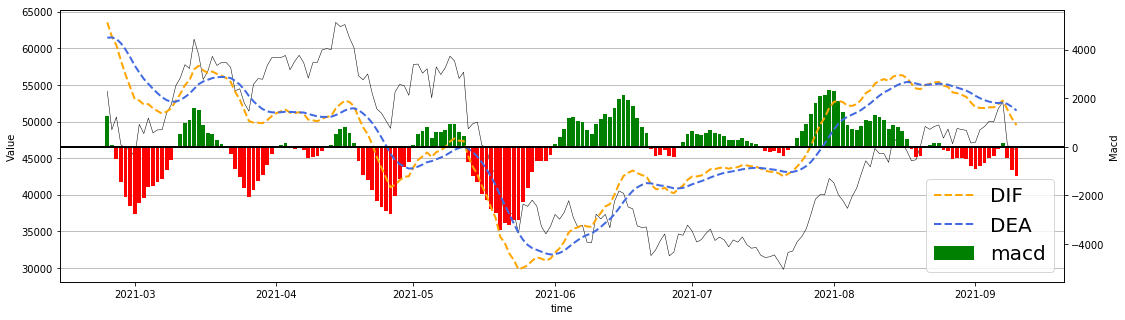

In [49]:
fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(111)
#fig.bar(dw.index, dw.volume, align='center', width=1.0)
ax1.plot(bchain.Date[-200:],bchain.Value[-200:], color='black',linewidth=0.5,linestyle='solid',label='close value')
ax2 =ax1.twinx()
ax2.bar(bchain.Date[-200:],macdhist[-200:]*2,label='macd',color = c[-200:],width=np.timedelta64(20, 'h'))
ax2.plot(bchain.Date[-200:],macd[-200:],label='DIF',c = 'orange',linewidth=2,linestyle='--')
ax2.plot(bchain.Date[-200:],signel[-200:],label='DEA',c = 'royalblue',linewidth=2,linestyle='--')

# ax1.set_ylabel("price", fontsize=16)
# ax2.set_ylabel('Bolliger Bander', fontsize=16)
# ax1.set_title("绿色是股票价格，红色（右轴）布林带", fontsize=16)
# plt.xticks(bar_data.index.values, bar_data.barNo.values)
# ax1.set_xlabel("Decade",fontsize=16)
# ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
# ax2.set_ylim(-3000,3000)
plt.axhline(y=0, xmin=0, xmax=1,c = 'black',linewidth = 2)
ax1.grid(axis='y')
ax1.set_xlabel('time')
ax2.set_ylabel('Macd')
ax1.set_ylabel('Value')
plt.legend(fontsize = 20)
# plt.savefig('macd.svg')

In [51]:
# 相对强弱指数
RSI_14 = talib.RSI(bchain['Value'].values, timeperiod=14)
RSI_30 = talib.RSI(bchain['Value'].values, timeperiod=30)

In [52]:
RSI_14

array([        nan,         nan,         nan, ..., 47.82867338,
       45.95007202, 46.84329206])

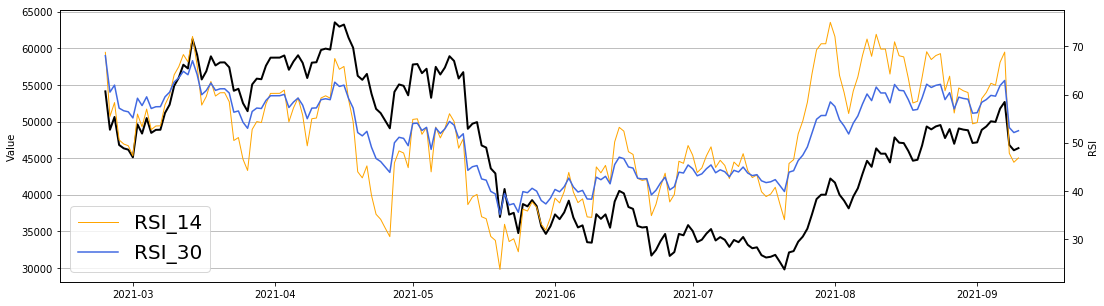

In [53]:
fig = plt.figure(figsize=(18,5))
ax1 = fig.add_subplot(111)
#fig.bar(dw.index, dw.volume, align='center', width=1.0)
ax1.plot(bchain.Date[-200:],bchain.Value[-200:], color='black',linewidth=2,linestyle='solid',label='close value')
ax2 = ax1.twinx()
ax2.plot(bchain.Date[-200:],RSI_14[-200:],label='RSI_14',c = 'orange',linewidth=1)
ax2.plot(bchain.Date[-200:],RSI_30[-200:],label='RSI_30',c = 'royalblue',linewidth=1.5)
ax1.grid(axis='y')
# axs1.set_xlabel('time')
ax2.set_ylabel('RSI')
ax1.set_ylabel('Value')
plt.legend(fontsize = 20)
# ax1.set_ylabel("price", fontsize=16)
# ax2.set_ylabel('Bolliger Bander', fontsize=16)
# ax1.set_title("绿色是股票价格，红色（右轴）布林带", fontsize=16)
# plt.xticks(bar_data.index.values, bar_data.barNo.values)
# ax1.set_xlabel("Decade",fontsize=16)
# ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
# ax2.set_ylim(-3000,3000)
# plt.axhline(y=0, xmin=0, xmax=1,c = 'black',linewidth = 2)
plt.savefig('RSI.svg')

# fig,ax= plt.subplots(2,1)
# fig.set_size_inches(18,10)
# ax[0].plot(bchain.Date[-200:],bchain.Value[-200:])
# ax[1].plot(bchain.Date[-200:],RSI_14[-200:],label='14',c = 'orange')
# ax[1].plot(bchain.Date[-200:],RSI_30[-200:],label='30',c = 'royalblue')
# ax[0].xaxis.set_major_locator(ticker.MultipleLocator(base=200))
# ax[1].xaxis.set_major_locator(ticker.MultipleLocator(base=20))
# plt.legend(loc='best')
# plt.show()

In [54]:
# BOLL
upper, middle, lower = talib.BBANDS(
                bchain['Value'].values ,
                timeperiod=20,
                # number of non-biased standard deviations from the mean
                nbdevup=2,
                nbdevdn=2,
                # Moving average type: simple moving average here
                matype=0)

E:\anaconda3\lib\site-packages\matplotlib\figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


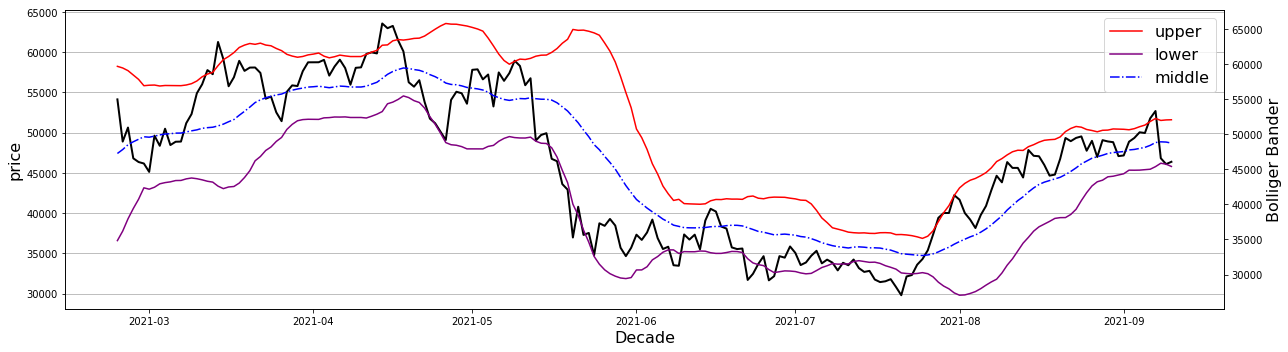

In [56]:
fig = plt.figure(figsize=(18,5))
fig.set_tight_layout(True)
ax1 = fig.add_subplot(111)
#fig.bar(dw.index, dw.volume, align='center', width=1.0)

ax1.plot(bchain.Date[-200:],bchain.Value[-200:], color='black',label='value',linewidth=2,linestyle='-')
ax2 =ax1.twinx()
ax2.plot(bchain.Date[-200:], upper[-200:], '-', color='r',label='upper')
ax2.plot(bchain.Date[-200:], lower[-200:], '-', color='purple',label='lower')
ax2.plot(bchain.Date[-200:], middle[-200:], '-.', color='b',label='middle')

ax1.set_ylabel("price", fontsize=16)
ax2.set_ylabel('Bolliger Bander', fontsize=16)
# ax1.set_title("绿色是股票价格，红色（右轴）布林带", fontsize=16)
# plt.xticks(bar_data.index.values, bar_data.barNo.values)
ax1.set_xlabel("Decade",fontsize=16)
# ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=10))
ax1.grid(axis='y')
plt.legend(fontsize = 16)
plt.savefig('boling.svg')

## 随机森林 ##

In [57]:
# 归一化
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_wine
from sklearn.model_selection import cross_val_score
import math

In [59]:
RSI = talib.RSI(bchain['Value'].values, timeperiod=7)

In [60]:
row=50
bc_all_feature = pd.DataFrame([b_HV_7[row-7:],
                               upper[row:],
                               lower[row:],
                               RSI[row:],
                               macdhist[row:],
                               bchain.iloc[row:,1],
                               bchain.index[row:]
                              ]
                             ).T

E:\anaconda3\lib\site-packages\pandas\core\frame.py:7432: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


In [61]:
bc_all_feature.columns = ['volatility','bol_upper','bol_lower','RSI','macd','value','jindex']

In [62]:
bc_all_feature.head()

,volatility,bol_upper,bol_lower,RSI,macd,value,jindex
0,[],"[700.5373162434103, 706.4314561500206, 720.455...","[606.5816837565899, 606.8875438499796, 602.600...","[86.63855557039001, 77.9205357591443, 88.09394...","[5.354650532668346, 4.77186966803214, 6.334157...",50 702.00 51 697.01 52 73...,"RangeIndex(start=50, stop=1826, step=1)"


In [1616]:
# bchain

In [1617]:
# 效果比较 1.昨日的钱和昨日的各项指标
#         2. 30日的钱和各项指标

In [1618]:
# 1
temp = bc_all_feature.value - bc_all_feature.value.shift(1)
bc_label = []
for i in temp.index:
    if(temp[i]>0):
        bc_label.append(1)
    else:
        bc_label.append(0)

In [1619]:
# 第一个没有label
bc_label = bc_label[1:]

In [1620]:
# 最后一个没有label
bc_all_feature.iloc[0:-1,:].shape

(1775, 7)

In [1612]:
bc_feature = bc_all_feature.iloc[0:-1,:].copy()

In [1593]:
bc_all = pd.concat([bc_feature,pd.Series(bc_label,name='lable')],axis=1)

array([0.14364212, 0.14124278, 0.14208279, 0.1419152 , 0.12809778,
       0.16633557, 0.13668375])

In [1594]:
from sklearn.model_selection import train_test_split

In [1625]:
# 无法进行增量学习，只有一年预测半年的方式反复进行,365,142
score = []
proba = np.zeros([10,141,2])
pre_label = np.zeros([10,141])
for i in range(10):
    rfc = RandomForestClassifier(n_estimators= 200,random_state=0,max_depth=8)
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(bc_feature.iloc[i*141:i*141+365,:-1].values,bc_label[i*141:i*141+365],test_size=0.1)
    rfc = rfc.fit(Xtrain, Ytrain)
    score.append(rfc.score(Xtest, Ytest))
    proba[i] = (rfc.predict_proba(bc_feature.iloc[i*141+365:(i+1)*141+365,:-1].values))
    pre_label[i] = (rfc.predict(bc_feature.iloc[i*141+365:(i+1)*141+365,:-1].values))

In [1626]:
sum(score)/len(score)

0.5621621621621622

In [1627]:
bc_feature_importance = rfc.feature_importances_

In [1628]:
bc_feature_importance

array([0.1637031 , 0.16809004, 0.1718288 , 0.17856817, 0.14663649,
       0.1711734 ])

In [1629]:
down = proba[:,:,0].flatten().copy()
up = proba[:,:,1].flatten().copy()

In [1630]:
bc_all['up'] = np.nan
bc_all['down'] = np.nan

In [1631]:
bc_all.iloc[-1410:,8] = down
bc_all.iloc[-1410:,9] = up

In [1632]:
bc_all['Date'] = pd.Series(bchain['Date'].iloc[50:].values)

In [1633]:
upp = bc_all.loc[(bc_all['Date'].dt.year == 2019) & (bc_all['up']>0.62)].index.tolist()

In [1634]:
downn = bc_all.loc[(bc_all['Date'].dt.year == 2019) & (bc_all['down']>0.65)].index.tolist()

In [1635]:
upp = upp + downn

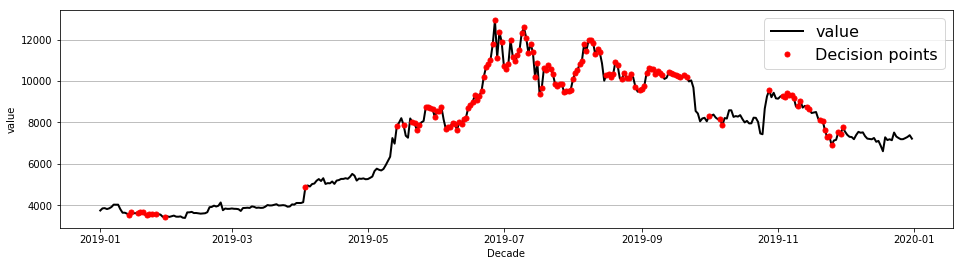

In [1636]:
fig = plt.figure(figsize=(16,4))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(111)
#fig.bar(dw.index, dw.volume, align='center', width=1.0)

ax1.plot(bc_all.loc[(bc_all['Date'].dt.year == 2019),'Date'],
         bc_all.loc[(bc_all['Date'].dt.year == 2019),'value'], 
         color='black',label='value',linewidth=2,linestyle='-')
ax1.plot_date(
            bc_all.loc[upp,'Date'], 
            bc_all.loc[upp,'value'],
            fmt='ro',
#             color = (150/255,84/255,84/255),
            ms = 5,
            label = 'Decision points'
           )
# ax1.plot_date(
#             bc_all.loc[downn,'Date'], 
#             bc_all.loc[downn,'value'],
#             fmt='ro',
# #             color = (150/255,84/255,84/255),
#             ms = 5,
#             label = 'change'
#            )
ax1.set_ylabel("value", fontsize=10)
# ax1.set_title("绿色是股票价格，红色（右轴）布林带", fontsize=16)
# plt.xticks(bar_data.index.values, bar_data.barNo.values)
ax1.set_xlabel("Decade",fontsize=10)
# ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=10))
ax1.grid(axis='y')
plt.legend(fontsize = 16)
plt.savefig('bchain_2019.svg')

In [1430]:
bc_all.to_csv('bc_all.csv')

In [1015]:
index_2019 = bchain.loc[(bchain['Date'].dt.year == 2019),'Date'].index

(1826, 2)

In [1022]:
list2019 = index_2019.tolist()

In [1029]:
c = np.array(c)

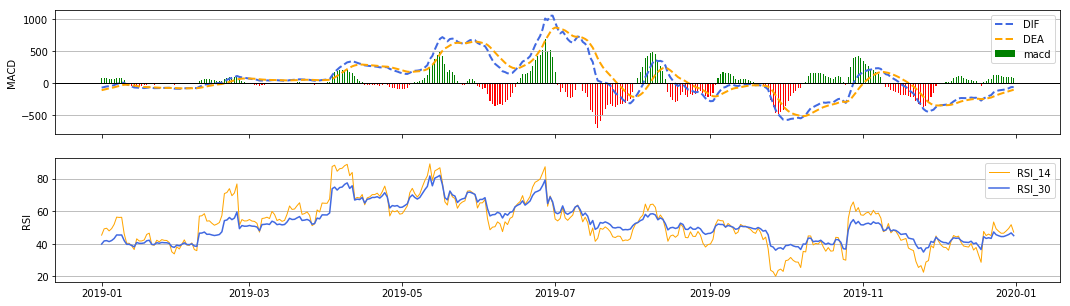

In [1050]:
fig, axes = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(18,5)) 
# fig.suptitle('Title of this figure')

# macd
ax1 = axes[0]
# axes1.plot(x, y1, color='#1f77b4', ls='--', label='Y1: Mean=%.2f'%np.mean(y1))
# axes1.legend()
ax1.bar( 
        bchain.loc[(bchain['Date'].dt.year == 2019),'Date'],
        macdhist[index_2019]*2,
        label='macd',
        color = c[index_2019],
        width=np.timedelta64(10, 'h')
        )
ax1.plot(
         bchain.loc[(bchain['Date'].dt.year == 2019),'Date'],
         macd[index_2019],
         label='DIF',
         c = 'royalblue',
         linewidth=2,
         linestyle='--'
        )
ax1.plot(
         bchain.loc[(bchain['Date'].dt.year == 2019),'Date'],
         signel[index_2019],
         label='DEA',
         c = 'orange',
         linewidth=2,
         linestyle='--'
        )
ax1.axhline(y=0, xmin=0, xmax=1,c = 'black',linewidth = 1)
ax1.grid(axis='y')
ax1.legend()

ax1.set_ylabel("MACD")
# # ax2.set_ylabel('Bolliger Bander', fontsize=16)
# # ax1.set_title("绿色是股票价格，红色（右轴）布林带", fontsize=16)
# # plt.xticks(bar_data.index.values, bar_data.barNo.values)
# # ax1.set_xlabel("Decade",fontsize=16)
# # ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
# # ax2.set_ylim(-3000,3000)
# plt.axhline(y=0, xmin=0, xmax=1,c = 'black',linewidth = 2)
# ax1.grid(axis='y')
# axs1.set_xlabel('time')
# ax2.set_ylabel('Macd')
# ax1.set_ylabel('Value')
# plt.legend(fontsize = 20)

#subplot2
ax2 = axes[1]
# ax2.plot(x, y2, color='#ff7f0e', ls='--', label='Y2: Mean=%.2f'%np.mean(y2))
# axes2.set_yticks(np.arange(0,30,10))
# axes2.legend()
ax2.plot(
         bchain.loc[(bchain['Date'].dt.year == 2019),'Date'],
         RSI_14[index_2019],
         label='RSI_14',
         c = 'orange',
         linewidth=1,
        )
ax2.plot(
         bchain.loc[(bchain['Date'].dt.year == 2019),'Date'],
         RSI_30[index_2019],
         label='RSI_30',
         c = 'royalblue',
         linewidth=1.5
        )
ax2.grid(axis='y')
ax2.legend()
ax2.set_ylabel('RSI')
plt.savefig('macd_RSI.svg')
# #subplot3
# axes3 = axes[2]
# axes3.plot(x, y3, 'g--', label='Y3: Mean=%.2f'%np.mean(y3))
# axes3.set_yticks(np.arange(0,20,5))
# axes3.set_xticks(x)
# axes3.grid(True) #是否产生网格
# axes3.legend()


In [1637]:
# lbma 找点
# 删除缺失值
lbma.drop(lbma[lbma['USD (PM)'].isnull()].index,inplace=True)
lbma['Date'] = lbma['Date'].astype('datetime64')

KeyError: 'USD (PM)'

In [1638]:
lbma.shape

(1255, 2)

In [1639]:
lbma.columns = ['Date','Value']

In [1640]:
lb_macd, lb_signel, lb_macdhist = talib.MACD(lbma['Value'].values, fastperiod=12, slowperiod=26, signalperiod=9)
lb_RSI_14 = talib.RSI(lbma['Value'].values, timeperiod=14)
lb_upper, lb_middle, lb_lower = talib.BBANDS(
                lbma['Value'].values ,
                timeperiod=20,
                # number of non-biased standard deviations from the mean
                nbdevup=2,
                nbdevdn=2,
                # Moving average type: simple moving average here
                matype=0)

In [1641]:
lb_macd.shape

(1255,)

In [1642]:
l_HV_7 = l_HV_7.flatten()

In [1643]:
lb_all_feature = pd.DataFrame([lbma.index[row:],l_HV_7[row-7:],lb_upper[row:],lb_lower[row:],lb_RSI_14[row:],lb_macdhist[row:],
                               lbma.iloc[row:,1]],
                               dtype=np.float64).T

In [1644]:
lb_all_feature.columns = ['jindex','volatility','bol_upper','bol_lower','RSI','macd','value']

In [1645]:
lb_all_feature.head()

,jindex,volatility,bol_upper,bol_lower,RSI,macd,value
0,50.0,19.516782,1322.073966,1199.891034,31.004053,-5.180262,1214.25
1,51.0,15.769137,1322.625438,1193.624562,30.474329,-4.760440,1212.25
2,52.0,11.271498,1325.396608,1182.338392,24.428736,-5.827839,1185.35
3,53.0,14.309519,1326.931360,1172.788640,24.876218,-5.993604,1186.10
4,54.0,14.058988,1326.421449,1164.768551,25.884476,-5.517646,1187.70


In [1646]:
lb_all_feature.shape

(1205, 7)

In [1647]:
lb_temp = lb_all_feature.value - lb_all_feature.value.shift(1)
lb_label = []
for i in lb_temp.index:
    if(lb_temp[i]>0):
        lb_label.append(1)
    else:
        lb_label.append(0)

In [1648]:
lb_label = lb_label[1:]

In [1649]:
lb_all_feature = lb_all_feature.iloc[:-1,:]

In [1650]:
lb_feature = lb_all_feature.copy()

In [1651]:
# 共1204
lb_score = []
lb_proba = np.zeros([10,100,2])
lb_pre = np.zeros([10,100])
for i in range(10):
    rfc = RandomForestClassifier(n_estimators= 190,random_state=0,max_depth=7)
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(lb_feature.iloc[i*100:i*100+204,1:].values,lb_label[i*100:i*100+204],test_size=0.1)
    rfc = rfc.fit(Xtrain, Ytrain)
    lb_score.append(rfc.score(Xtest, Ytest))
    lb_proba[i] = (rfc.predict_proba(lb_feature.iloc[i*100+204:(i+1)*100+204,1:].values))
    lb_pre[i] = (rfc.predict(lb_feature.iloc[i*100+204:(i+1)*100+204,1:].values))

In [1652]:
sum(lb_score)/len(lb_score)


0.5238095238095237

In [1653]:
lb_feature_importance = rfc.feature_importances_

In [1655]:
lb_feature_importance
bc_feature_importance

array([0.1637031 , 0.16809004, 0.1718288 , 0.17856817, 0.14663649,
       0.1711734 ])

In [1191]:
lb_feature.shape

(1204, 7)

In [1469]:
lb_feature = pd.concat([lb_feature,pd.Series(lbma.Date[50:-1].values,name='Date')],axis=1)

In [1470]:
lb_down = lb_proba[:,:,0].flatten()

In [1471]:
lb_up = lb_proba[:,:,1].flatten()

In [1472]:
lb_feature['up'] = np.nan
lb_feature['down'] = np.nan

In [1473]:
lb_up.shape

(1000,)

In [1474]:
bc_feature.shape

(1775, 7)

In [1475]:
lb_feature.iloc[-1000:,8] = lb_up
lb_feature.iloc[-1000:,9] = lb_down

In [1541]:
lb_feature.loc[(lb_feature['Date'].dt.year == 2019) & (lb_feature['up']>0.6)]

,jindex,volatility,bol_upper,bol_lower,RSI,macd,value,Date,up,down
568,624.0,8.048864,1339.364769,1300.765231,53.927313,-1.768698,1319.15,2019-02-28,0.600990,0.399010
572,628.0,10.484697,1347.319902,1283.765098,36.133543,-6.611063,1285.85,2019-03-06,0.622170,0.377830
573,629.0,11.430716,1348.665618,1279.949382,35.886514,-6.619409,1285.30,2019-03-07,0.607515,0.392485
607,663.0,7.331731,1308.457807,1267.307193,45.576092,-0.854958,1284.20,2019-04-26,0.615831,0.384169
762,818.0,6.924624,1480.757428,1448.307572,52.247289,2.300530,1475.10,2019-12-04,0.614491,0.385509
763,819.0,6.639104,1478.639045,1449.595955,52.804787,2.762223,1475.95,2019-12-05,0.633523,0.366477


In [1481]:
lb_feature.loc[(lb_feature['Date'].dt.year == 2019) & (lb_feature['down']>0.77)]

,jindex,volatility,bol_upper,bol_lower,RSI,macd,value,Date,up,down
527,583.0,5.305247,1278.922840,1215.217160,75.990207,3.624241,1282.90,2019-01-02,0.201848,0.798152
528,584.0,5.386124,1285.819519,1214.740481,78.272754,4.175900,1290.45,2019-01-03,0.212123,0.787877
529,585.0,5.242262,1287.827145,1218.967855,68.476438,3.538253,1279.90,2019-01-04,0.198886,0.801114
540,596.0,4.050763,1308.534237,1251.610763,55.861989,-2.089737,1279.55,2019-01-21,0.205614,0.794386
548,604.0,4.896413,1314.212565,1270.292435,76.606357,1.553856,1323.25,2019-01-31,0.223571,0.776429
549,605.0,4.102756,1318.204315,1270.180685,72.078944,1.778518,1318.70,2019-02-01,0.206458,0.793542
664,720.0,8.233608,1426.838919,1385.086081,62.609056,-2.285056,1417.45,2019-07-18,0.219275,0.780725
690,746.0,8.585823,1551.031476,1409.823524,64.674686,-1.897298,1503.80,2019-08-23,0.215870,0.784130
703,759.0,8.476157,1549.860604,1485.724396,54.843440,-6.776748,1515.20,2019-09-12,0.210318,0.789682
711,767.0,8.757149,1549.075962,1484.224038,57.216167,-2.148240,1520.65,2019-09-24,0.170141,0.829859


In [1523]:
lb_upp = lb_feature.loc[(lb_feature['Date'].dt.year == 2019) & (lb_feature['up']>0.7)].index.tolist()
lb_downn = lb_feature.loc[(lb_feature['Date'].dt.year == 2019) & (lb_feature['down']>0.66)].index

In [1525]:
lb_downn = lb_downn[lb_downn>539].tolist()

In [1529]:
lb_points = lb_downn + lb_upp + [640,642,645,647,649,651,637,628,725,745,743,735,739]

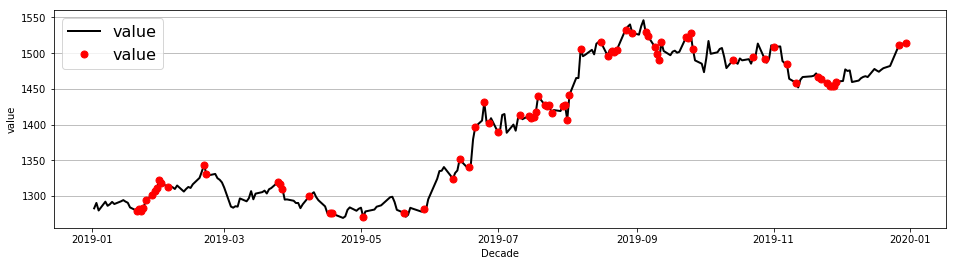

In [1531]:
fig = plt.figure(figsize=(16,4))
# fig.set_tight_layout(True)
ax1 = fig.add_subplot(111)
#fig.bar(dw.index, dw.volume, align='center', width=1.0)

ax1.plot(lb_feature.loc[(lb_feature['Date'].dt.year == 2019),'Date'],
         lb_feature.loc[(lb_feature['Date'].dt.year == 2019),'value'], 
         color='black',label='value',linewidth=2,linestyle='-')
ax1.plot_date(
           lb_feature.loc[lb_points,'Date'], 
           lb_feature.loc[lb_points,'value'],
            fmt='o',
            color = 'r',
            ms = 7,
            label = None
           )
# ax1.plot_date(
#             lb_feature.loc[lb_downn,'Date'], 
#             lb_feature.loc[lb_downn,'value'],
#             fmt='o',
#             color = 'royalblue',
#             ms = 7,
#             label = 'change'
#            )
# ax1.plot_date(
#             lb_feature.loc[[640,642,645,647,649,651,637,628,725,745,743,735,739],'Date'], 
#             lb_feature.loc[[640,642,644,647,649,651,637,628,725,745,743,735,739],'value'],
#             fmt='o',
#             color = 'r',
#             ms = 7,
#             label = 'change'
#            )
ax1.set_ylabel("value", fontsize=10)
# ax1.set_title("绿色是股票价格，红色（右轴）布林带", fontsize=16)
# plt.xticks(bar_data.index.values, bar_data.barNo.values)
ax1.set_xlabel("Decade",fontsize=10)
# ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=10))
ax1.grid(axis='y')
plt.legend(fontsize = 16)
plt.savefig('lbam_2019.svg')

In [1532]:
rfc.feature_importances_

array([0.19629959, 0.16726656, 0.15134395, 0.1768384 , 0.15553444,
       0.15271705])

In [1537]:
from sklearn import tree
import graphviz

In [1549]:
lb_feature

,jindex,volatility,bol_upper,bol_lower,RSI,macd,value,Date,up,down
0,50.0,19.516782,1322.073966,1199.891034,31.004053,-5.180262,1214.25,2016-11-21,NaN,NaN
1,51.0,15.769137,1322.625438,1193.624562,30.474329,-4.760440,1212.25,2016-11-22,NaN,NaN
2,52.0,11.271498,1325.396608,1182.338392,24.428736,-5.827839,1185.35,2016-11-23,NaN,NaN
3,53.0,14.309519,1326.931360,1172.788640,24.876218,-5.993604,1186.10,2016-11-24,NaN,NaN
4,54.0,14.058988,1326.421449,1164.768551,25.884476,-5.517646,1187.70,2016-11-25,NaN,NaN
5,55.0,14.581171,1325.058170,1157.631830,25.721824,-4.798624,1187.00,2016-11-28,NaN,NaN
6,56.0,13.708814,1320.278454,1152.221546,25.610412,-3.938056,1186.55,2016-11-29,NaN,NaN
7,57.0,13.258760,1311.624932,1148.310068,23.547821,-3.535447,1178.10,2016-11-30,NaN,NaN
8,58.0,13.274953,1302.967392,1143.052608,20.181661,-3.930703,1161.85,2016-12-01,NaN,NaN
9,59.0,8.674500,1290.321412,1142.768588,28.115387,-3.015853,1173.50,2016-12-02,NaN,NaN


In [1553]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(lb_feature.iloc[7*100:7*100+204,1:7].values,lb_label[7*100:7*100+204],test_size=0.2)

In [1578]:
clf = tree.DecisionTreeClassifier(max_depth=3
                                    ,criterion="entropy"
#                                     ,random_state=30
                                    ,splitter="random"
                                    )
clf.fit(Xtrain, Ytrain)

DecisionTreeClassifier(criterion='entropy', max_depth=3, splitter='random')

In [1579]:
clf.score(Xtest, Ytest)

0.5853658536585366

In [1556]:
clf.feature_importances_

array([0.24273528, 0.0930803 , 0.11314102, 0.22720903, 0.18824727,
       0.1355871 ])

In [1558]:
feature = ['volatility','bol_upper','bol_lower','RSI','macd','value']

In [1580]:
dot_data = tree.export_graphviz(clf
                                ,feature_names= feature
                                ,filled=True #填充颜色
                                ,rounded=True
                                )
graph = graphviz.Source(dot_data)

In [1581]:
graph = graphviz.Source(dot_data)

In [1583]:
print(graph.source)

digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="RSI <= 52.147\nentropy = 0.997\nsamples = 163\nvalue = [76, 87]", fillcolor="#e6f3fc"] ;
1 [label="bol_lower <= 1642.077\nentropy = 0.969\nsamples = 63\nvalue = [25, 38]", fillcolor="#bbddf6"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="volatility <= 40.427\nentropy = 0.988\nsamples = 55\nvalue = [24, 31]", fillcolor="#d2e9f9"] ;
1 -> 2 ;
3 [label="entropy = 0.996\nsamples = 52\nvalue = [24, 28]", fillcolor="#e3f1fb"] ;
2 -> 3 ;
4 [label="entropy = 0.0\nsamples = 3\nvalue = [0, 3]", fillcolor="#399de5"] ;
2 -> 4 ;
5 [label="bol_lower <= 1684.826\nentropy = 0.544\nsamples = 8\nvalue = [1, 7]", fillcolor="#55abe9"] ;
1 -> 5 ;
6 [label="entropy = 0.0\nsamples = 5\nvalue = [0, 5]", fillcolor="#399de5"] ;
5 -> 6 ;
7 [label="entropy = 0.918\nsamples = 3\nvalue = [1, 2]", fillcolor="#9ccef2"] ;
5 -> 7 ;
8 [label="RSI <= 83.066\ne

In [1656]:
feature_label = ['volatility','bol_upper','bol_lower','RSI','macd','value']

In [1665]:
bc_all_feature = bc_feature_importance.tolist()

In [1677]:
bc_feature_importance

array([0.1637031 , 0.16809004, 0.1718288 , 0.17856817, 0.14663649,
       0.1711734 ])

In [1678]:
lb_feature_importance

array([0.17453742, 0.15838449, 0.15179963, 0.18622897, 0.16727235,
       0.16177714])

In [ ]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(len())


error = np.random.rand(len(people))


barth_width = 0.3
# width = total_width / n
# y_pos=y_pos - (total_width - width) / 2

b=ax.barh(y_pos, compare_data[:,0], align='center',
        color=(16/255,109/255,156/255), ecolor='black',height=0.3,label='follower')
# #添加数据标签
# for rect in b:
#     w=rect.get_width()
#     ax.text(w,rect.get_y()+rect.get_height()/2,'%f'%w,ha='left',va='center')

b=ax.barh(y_pos+barth_width, compare_data[:,1], align='center',
        color=(1,97/255,0), ecolor='black',height=0.3,label='Random')
# #添加数据标签
# for rect in b:
#     w=rect.get_width()
#     ax.text(w,rect.get_y()+rect.get_height()/2,'%f'%w,ha='left',va='center')
ax.set_yticks(y_pos+width/2.0)
ax.set_yticklabels(index,fontsize = 9)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Spearman Parameter', fontsize = 9)
# ax.set_title('How fast do you want to go today?')
plt.legend(loc = 2, bbox_to_anchor = (1.05, 1.0), borderaxespad = 0, fontsize = 9)
plt.savefig('inf_random.svg',bbox_inches="tight")

**RNN** 尝试

In [218]:
# 10天均线变化
bc_all_feature = pd.DataFrame([b_HV_7[row-7:],upper[row:],lower[row:],RSI[row:],macdhist[50:],bchain.iloc[row:,1]]).T

In [341]:
bc_train = []
for i in range(60, len(bc_data)):
    bc_train.append(bc_data[i-60:i,0])

In [345]:
bc_train = np.array(bc_train)

In [343]:
bc_label = np.array(label[59:])

In [416]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(bc_train,bc_label,test_size=0.1)

In [421]:
bc_train

array([[4.37894574e-04, 2.47616119e-04, 2.67469881e-04, ...,
        1.84052315e-03, 1.82479897e-03, 2.01475976e-03],
       [2.47616119e-04, 2.67469881e-04, 2.34115561e-04, ...,
        1.82479897e-03, 2.01475976e-03, 2.02381308e-03],
       [2.67469881e-04, 2.34115561e-04, 2.58893056e-04, ...,
        2.01475976e-03, 2.02381308e-03, 1.92772087e-03],
       ...,
       [5.27704098e-01, 5.22892341e-01, 5.34202155e-01, ...,
        7.83878936e-01, 8.12812697e-01, 8.27239870e-01],
       [5.22892341e-01, 5.34202155e-01, 5.17217024e-01, ...,
        8.12812697e-01, 8.27239870e-01, 7.34034716e-01],
       [5.34202155e-01, 5.17217024e-01, 5.09725167e-01, ...,
        8.27239870e-01, 7.34034716e-01, 7.22427572e-01]])

In [383]:
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], 60, 1))

In [384]:
Xtrain.shape

(1236, 60, 1)

In [385]:
Xtest.shape

(530, 60, 1)

In [375]:
Xtest = np.reshape(Xtest, (Xtest.shape[0], 60, 1))

In [497]:
row=50

In [498]:
bc_all_feature = pd.DataFrame([b_HV_7[row-7:],upper[row:],lower[row:],RSI[row:],macdhist[50:],bchain.iloc[row:,1]]).T

In [331]:
train_set = bc_all_feature.iloc[1000:1826-166,:].values
test_set = bc_all_feature.iloc[1826-166:,:].values

In [332]:
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(train_set)
test_set = sc.transform(test_set)

In [333]:
x_train = []
y_train = []

x_test = []
y_test = []

In [335]:
training_set_scaled.shape

(660, 6)

In [336]:
# 数据格式转换30步
for i in range(60, training_set_scaled.shape[0]):
    x_train.append(training_set_scaled[i-60:i, :])
    y_train.append(training_set_scaled[i, :])

In [337]:
# 3 dimension(size,step,feature)
for i in range(60, test_set.shape[0]):
    x_test.append(test_set[i - 60:i, :])
    y_test.append(test_set[i, :])

In [340]:
x_test.shape

(56, 60, 6)

In [341]:
x_train.shape

(600, 60, 6)

In [342]:
x_test, y_test = np.array(x_test), np.array(y_test)
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], 60,6))
x_test = np.reshape(x_test, (x_test.shape[0], 60, 6))

In [343]:
# 数据打乱
np.random.seed(7) # 任意随机种子
np.random.shuffle(x_train)
np.random.seed(7) # 任意随机种子
np.random.shuffle(y_train)

In [344]:
x_test.shape

(56, 60, 6)

In [345]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN, GRU, LSTM

In [346]:
# model 搭建 RN默认激活tanh,Dense默认激活linear
model = tf.keras.Sequential([
    GRU(80, return_sequences=True),
    Dropout(0.2),
    GRU(180,return_sequences=True),
    Dropout(0.2),
    GRU(200),
    Dropout(0.2),
    Dense(6)
])

In [347]:
# 优化器选择，loss选择
model.compile(optimizer=tf.keras.optimizers.Adam(0.02),
              loss='mse'
             )

In [ ]:
model.save()

In [348]:
history = model.fit(x_train, y_train, batch_size=128,epochs=30,
                    validation_data=(x_test, y_test),
                   )

Train on 600 samples, validate on 56 samples
Epoch 1/30
600/600 [==============================] - 7s 11ms/sample - loss: 0.6477 - val_loss: 0.1064
Epoch 2/30
600/600 [==============================] - 2s 4ms/sample - loss: 0.1141 - val_loss: 0.0480
Epoch 3/30
600/600 [==============================] - 2s 4ms/sample - loss: 0.0727 - val_loss: 0.0372
Epoch 4/30
600/600 [==============================] - 3s 4ms/sample - loss: 0.0383 - val_loss: 0.0262
Epoch 5/30
600/600 [==============================] - 3s 5ms/sample - loss: 0.0225 - val_loss: 0.0240
Epoch 6/30
600/600 [==============================] - 3s 5ms/sample - loss: 0.0196 - val_loss: 0.0164
Epoch 7/30
600/600 [==============================] - 3s 5ms/sample - loss: 0.0160 - val_loss: 0.0095
Epoch 8/30
600/600 [==============================] - 3s 5ms/sample - loss: 0.0138 - val_loss: 0.0163
Epoch 9/30
600/600 [==============================] - 3s 5ms/sample - loss: 0.0126 - val_loss: 0.0134
Epoch 10/30
600/600 [===============

In [351]:
pre_price = sc.inverse_transform(model.predict(x_test))
re_price = sc.inverse_transform(test_set[60:])

In [354]:
pre_price[:,5]

array([32400.4  , 31866.076, 31607.086, 31978.076, 30872.209, 29885.459,
       32871.17 , 32568.742, 33705.793, 34065.09 , 34691.355, 35272.797,
       35939.19 , 36632.79 , 37363.586, 38279.11 , 38835.22 , 39191.04 ,
       39644.293, 39215.016, 39752.19 , 40049.285, 40727.812, 41541.99 ,
       41597.703, 42634.33 , 42597.098, 43334.406, 42974.875, 44177.566,
       43913.47 , 44426.12 , 43759.5  , 43118.188, 43022.547, 43950.547,
       44865.59 , 45228.004, 46041.83 , 46300.027, 45360.688, 46371.285,
       44851.08 , 46153.28 , 46145.363, 46453.637, 45373.47 , 45478.754,
       46807.723, 46922.453, 47676.094, 47909.652, 48975.027, 49512.55 ,
       46765.875, 46681.613], dtype=float32)

In [355]:
re_price[:,5]

array([31421.25, 31520.66, 31783.49, 30815.94, 29790.24, 32118.06,
       32297.89, 33581.63, 34279.34, 35365.2 , 37318.14, 39405.95,
       40002.53, 40005.93, 42214.15, 41659.06, 40000.46, 39193.94,
       38138.  , 39750.14, 40882.  , 42825.95, 44634.13, 43816.14,
       46333.46, 45608.37, 45611.46, 44417.78, 47833.98, 47112.19,
       47056.41, 45982.55, 44648.57, 44777.86, 46734.65, 49327.75,
       48932.02, 49335.68, 49523.5 , 47744.58, 48972.09, 46962.8 ,
       49056.86, 48897.65, 48806.78, 47074.77, 47155.87, 48862.76,
       49329.01, 50035.33, 49947.38, 51769.06, 52677.4 , 46809.17,
       46078.38, 46368.69])

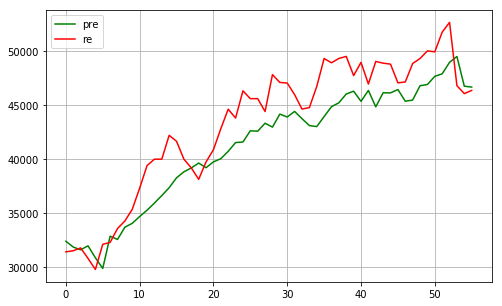

In [357]:
fig = plt.figure(figsize=(8, 5))
axs1 = fig.add_subplot(111)
axs1.plot(pre_price[:,5], c='g',label = 'pre')
axs1.plot(re_price[:,5],c='r',label = 're')
plt.legend()
plt.grid()
plt.show()

In [264]:
pre_test = x_test[0].copy()

In [265]:
pre_test = pre_test.reshape(1,60,1)

In [266]:
# pre_test = x_test[0].copy()
# pre_test = pre_test.reshape(1,60,1)
pre = []
for j in range(30):
    temp = []
    for i in pre_test[0,1:]:
        temp.append(i.tolist())
    pre.append(model.predict(pre_test).tolist())
    temp.append(model.predict(pre_test))
    pre_test = np.array(temp,dtype=np.float64).reshape(1,60,1)

E:\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  


In [267]:
# pre_price = model.predict()
pre_price = sc.inverse_transform(np.array(pre).reshape(-1,1)).flatten()
re_price = sc.inverse_transform(test_set[30:])

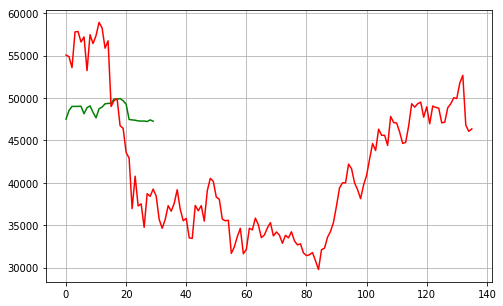

In [268]:
fig = plt.figure(figsize=(8, 5))
axs1 = fig.add_subplot(111)
axs1.plot(pre_price, c='g')
axs1.plot(re_price,c='r')
plt.grid()
plt.show()

In [398]:
value = []
for i in pre:
    if(i>0.5):
        value.append(1)
    

In [1711]:
lbma.shape

(1255, 2)

In [2387]:
lbma.shape

(1255, 2)

In [2388]:
# 进去某30天，出来10天 后面检验
train_set = lbma.iloc[850:1100,1:2].values
test_set = lbma.iloc[1070:1130,1:2].values

In [2389]:
from sklearn.preprocessing import MinMaxScaler
import math

In [2390]:
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(train_set)
test_set = sc.transform(test_set)
x_train = []
y_train = []

x_test = []
y_test = []

In [2391]:
# 数据格式转换30步
for i in range(30, len(training_set_scaled)):
    x_train.append(training_set_scaled[i-30:i, 0])
    y_train.append(training_set_scaled[i, 0])

In [2392]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], 30,1))

In [2393]:
x_train.shape

(220, 30, 1)

In [2394]:
# 预测数据格式转换
for i in range(30, len(test_set)):
    x_test.append(test_set[i - 30:i, 0])
    y_test.append(test_set[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)

In [2395]:
x_test.shape

(30, 30)

In [2396]:
x_test = np.reshape(x_test, (x_test.shape[0], 30, 1))

In [2397]:
# 数据打乱
np.random.seed(7) # 任意随机种子
np.random.shuffle(x_train)
np.random.seed(7) # 任意随机种子
np.random.shuffle(y_train)

In [2398]:
# 想用哪个改一下层就好
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN, GRU, LSTM

In [2399]:
# model 搭建 RN默认激活tanh,Dense默认激活linear
model = tf.keras.Sequential([
    SimpleRNN(80, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(140),
    Dropout(0.2),
    Dense(1)
])

In [2400]:
# 优化器选择，loss选择
model.compile(optimizer=tf.keras.optimizers.Adam(0.0015),
              loss='mse'
             )

In [2401]:
history = model.fit(x_train, y_train, batch_size=128,epochs=120,
                    validation_data=(x_test, y_test),
                   )

Train on 220 samples, validate on 30 samples
Epoch 1/120
220/220 [==============================] - 7s 32ms/sample - loss: 1.3546 - val_loss: 0.0215
Epoch 2/120
220/220 [==============================] - 0s 372us/sample - loss: 0.5980 - val_loss: 0.1165
Epoch 3/120
220/220 [==============================] - 0s 372us/sample - loss: 0.2931 - val_loss: 0.1757
Epoch 4/120
220/220 [==============================] - 0s 385us/sample - loss: 0.1792 - val_loss: 0.0048
Epoch 5/120
220/220 [==============================] - 0s 390us/sample - loss: 0.1556 - val_loss: 0.0035
Epoch 6/120
220/220 [==============================] - 0s 394us/sample - loss: 0.1399 - val_loss: 0.1114
Epoch 7/120
220/220 [==============================] - 0s 381us/sample - loss: 0.1466 - val_loss: 0.0066
Epoch 8/120
220/220 [==============================] - 0s 376us/sample - loss: 0.1085 - val_loss: 0.0041
Epoch 9/120
220/220 [==============================] - 0s 435us/sample - loss: 0.0941 - val_loss: 0.0480
Epoch 10/12

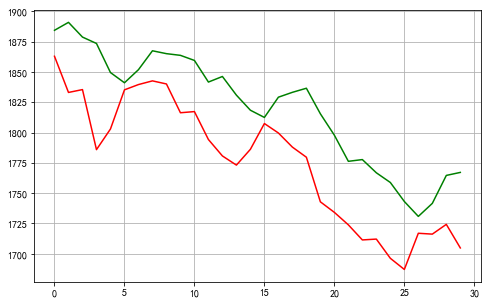

In [2404]:
# 简单检查
pre_price = model.predict(x_test)
pre_price = sc.inverse_transform(pre_price)
re_price = sc.inverse_transform(test_set[30:])
fig = plt.figure(figsize=(8, 5))
axs1 = fig.add_subplot(111)
axs1.plot(pre_price, c='g')
axs1.plot(re_price,c='r')
plt.grid()
plt.show()

In [2405]:
#
lb_mean_5 = []
lb_std_5 = []
for x in range(30):
    pre_test = x_test[x].copy()
    pre_test = pre_test.reshape(1,30,1)
    pre = []
    for j in range(5):
        temp = []
        for i in pre_test[0,1:]:
            temp.append(i.tolist())
        pre.append(model.predict(pre_test).tolist())
        temp.append(model.predict(pre_test))
        pre_test = np.array(temp,dtype=np.float64).reshape(1,30,1)
    pre_price = sc.inverse_transform(np.array(pre).reshape(-1,1)).flatten()
    lb_mean_5.append(pre_price.mean())
    lb_std_5.append(pre_price.std())

E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same Val

In [2409]:
lb_mre_5 = lbma.iloc[1100:1134,1:2].rolling(5).mean().dropna().values
lb_mstd_5 = lbma.iloc[1100:1134,1:2].rolling(5).std().dropna().values

In [2414]:
np.array(lb_mean_5) - 5

array([1908.32465681, 1913.83839679, 1902.85657558, 1897.35225007,
       1871.93412701, 1864.6590334 , 1875.63785781, 1881.79031147,
       1883.31700313, 1885.10793601, 1878.62850628, 1872.91508346,
       1867.84976758, 1852.01544554, 1842.418894  , 1842.94587802,
       1856.1985862 , 1856.78453787, 1851.71884032, 1839.86475312,
       1824.11046112, 1811.47830915, 1805.01144618, 1791.4720809 ,
       1784.74112868, 1775.64854096, 1770.7556823 , 1784.38783876,
       1791.98163897, 1788.18153356])

In [2420]:
lb_make = np.array(lb_std_5)*0.4+ lb_mstd_5.flatten()*0.5

E:\anaconda3\lib\site-packages\matplotlib\figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
E:\anaconda3\lib\site-packages\matplotlib\figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


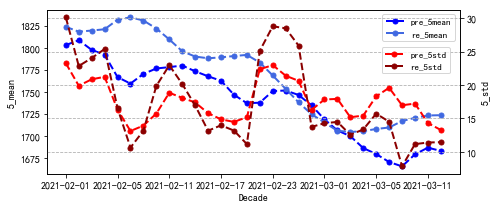

In [2423]:
name = ['pre_5mean','re_5mean','pre_5std','re_5std']
fig = plt.figure(figsize=(7,3))
fig.set_tight_layout(True)
ax1 = fig.add_subplot(111)
ax1.plot(lbma.Date[1100:1130],np.array(lb_mean_5) - 110,'--o', linewidth = 2, markersize = 5,label=name[0],c='b')
ax1.plot(lbma.Date[1100:1130],lb_mre_5,'--o', linewidth = 2, markersize = 5,label=name[1],c='royalblue')
ax2 =ax1.twinx()
ax2.plot(lbma.Date[1100:1130], lb_make, '--o', linewidth = 2, markersize = 5,label=name[2],c='red')
ax2.plot(lbma.Date[1100:1130], lb_mstd_5, '--o', linewidth = 2, markersize = 5,label=name[3],c='darkred')
# ax.plot(x_axis[:-1],value3[:-1,0],'--o', linewidth = 2.5, markersize = 6,label=name[2])
# ax.plot(x_axis[:-1],value4[:-1,0],'--o', linewidth = 2.5, markersize = 6,label=name[3])
# ax.plot(x_axis[:-1],value5[:-1,0],'--o', linewidth = 2.5, markersize = 6,label=name[4])
# ax.plot(had_year2,R_B_year[:,0])
# ax.plot(had_year3,cou_year[:,0])
ax1.set_xlabel("Decade", fontsize = 10)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=4))
ax1.set_ylabel('5_mean', fontsize = 10)
ax2.set_ylabel('5_std', fontsize = 10)
plt.grid(True, linestyle = '--',axis='y')
# plt.tick_params(labelsize = 18)
# plt.legend(loc = 2, bbox_to_anchor = (1.05, 1.0),fontsize = 9)
ax1.legend(fontsize = 9)
ax2.legend(loc = 2, bbox_to_anchor = (0.8, 0.8),fontsize = 9)
plt.savefig('lb_mean.svg',bbox_inches="tight")

In [2278]:
bc_mean_5 = []
bc_std_5 = []
for x in range(30):
    pre_test = x_test[x].copy()
    pre_test = pre_test.reshape(1,30,1)
    pre = []
    for j in range(5):
        temp = []
        for i in pre_test[0,1:]:
            temp.append(i.tolist())
        pre.append(model.predict(pre_test).tolist())
        temp.append(model.predict(pre_test))
        pre_test = np.array(temp,dtype=np.float64).reshape(1,30,1)
    pre_price = sc.inverse_transform(np.array(pre).reshape(-1,1)).flatten()
    bc_mean_5.append(pre_price.mean())
    bc_std_5.append(pre_price.std())

E:\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  del sys.path[0]
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  del sys.path[0]
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the futur

In [2300]:
bc_mre_5 = bchain.iloc[1600:1634,1:2].rolling(5).mean().dropna().values

In [2301]:
bc_mstd_5 = bchain.iloc[1600:1634,1:2].rolling(5).std().dropna().values

In [2302]:
bc_mre_5.shape

(30, 1)

In [2291]:
len(bc_mean_5)

30

In [2351]:
bc_make = bc_mstd_5.copy()

In [2357]:
bc_std_5

[463.81285891336285,
 646.336225830893,
 779.7991821360924,
 1086.746938822385,
 1487.5599337238614,
 1661.6995575390877,
 1341.7555091190397,
 859.7761013651278,
 1099.8388973494418,
 1614.9938812386517,
 1666.6966785652198,
 1339.0257684602961,
 1000.0544698586591,
 575.4911851623275,
 1181.201050380307,
 1557.8646910949408,
 694.3616000328824,
 558.6570946694661,
 269.3017332415667,
 292.38082027062023,
 470.57410103188806,
 661.7597166717482,
 1088.4981027269055,
 1169.2375883784944,
 1993.6895068212818,
 1276.7702060943236,
 1964.6430869916344,
 1764.3398725465029,
 1109.642540204759,
 2060.664608993937]

In [2376]:
bc_make = np.array(bc_std_5)*0.4+ bc_mstd_5.flatten()*0.5

In [2373]:
bc_make

array([1031.77453569,  595.75024798,  849.39655746, 1459.51586481,
       1756.46258045, 1784.64745124, 1381.18247889,  897.50474662,
       2388.05302614, 2906.7278574 , 2730.63509949, 2443.29930946,
       1099.88484042,  890.10315282, 1316.18065008, 1072.42647674,
        762.70833129, 1221.91978857, 1055.65232518, 1684.30658285,
       1713.56944406, 1633.35673414, 1670.66857861, 2259.93842004,
       2801.79285376, 2765.82531469, 2567.20279636, 1849.51867899,
       1612.06093237, 1874.89078161])

NameError: name 'bc_mean_5' is not defined

E:\anaconda3\lib\site-packages\matplotlib\figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


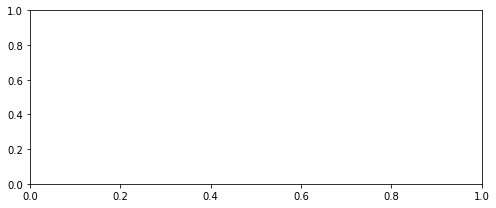

In [65]:
name = ['pre_5mean','re_5mean','pre_5std','re_5std']
fig = plt.figure(figsize=(7,3))
fig.set_tight_layout(True)
ax1 = fig.add_subplot(111)
ax1.plot(bchain.Date[1600:1630],bc_mean_5,'--o', linewidth = 2, markersize = 5,label=name[0],c='b')
ax1.plot(bchain.Date[1600:1630],bc_mre_5,'--o', linewidth = 2, markersize = 5,label=name[1],c='royalblue')
ax2 =ax1.twinx()
ax2.plot(bchain.Date[1600:1630], bc_std_5, '--o', linewidth = 2, markersize = 5,label=name[2],c='red')
ax2.plot(bchain.Date[1600:1630], bc_make, '--o', linewidth = 2, markersize = 5,label=name[3],c='darkred')
# ax.plot(x_axis[:-1],value3[:-1,0],'--o', linewidth = 2.5, markersize = 6,label=name[2])
# ax.plot(x_axis[:-1],value4[:-1,0],'--o', linewidth = 2.5, markersize = 6,label=name[3])
# ax.plot(x_axis[:-1],value5[:-1,0],'--o', linewidth = 2.5, markersize = 6,label=name[4])
# ax.plot(had_year2,R_B_year[:,0])
# ax.plot(had_year3,cou_year[:,0])
ax1.set_xlabel("Decade", fontsize = 10)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=4))
ax1.set_ylabel('5_mean', fontsize = 10)
ax2.set_ylabel('5_std', fontsize = 10)
plt.grid(True, linestyle = '--',axis='y')
# plt.tick_params(labelsize = 18)
# plt.legend(loc = 2, bbox_to_anchor = (1.05, 1.0),fontsize = 9)
ax1.legend(fontsize = 9)
ax2.legend(loc = 2, bbox_to_anchor = (0, 0.83),fontsize = 9)
plt.savefig('bc_mean.svg',bbox_inches="tight")

E:\anaconda3\lib\site-packages\matplotlib\figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


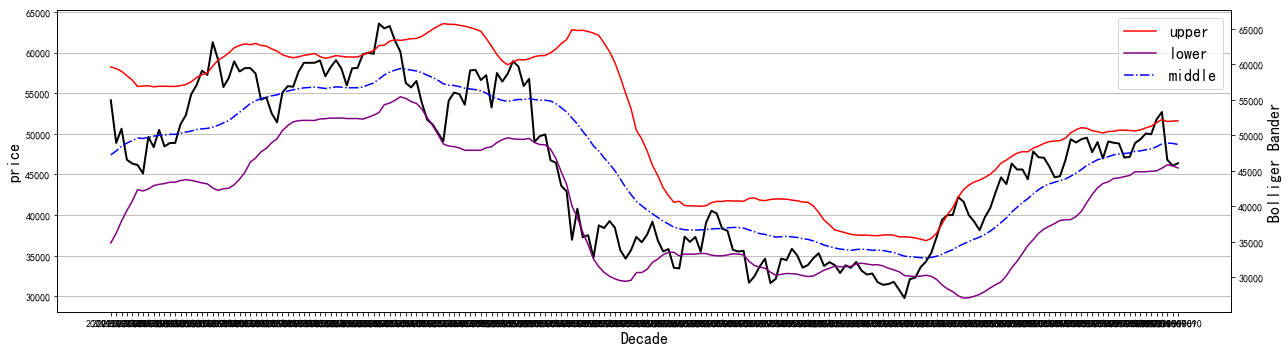

In [2318]:
fig = plt.figure(figsize=(18,5))
fig.set_tight_layout(True)
ax1 = fig.add_subplot(111)
#fig.bar(dw.index, dw.volume, align='center', width=1.0)

ax1.plot(bchain.Date[-200:],bchain.Value[-200:], color='black',label='value',linewidth=2,linestyle='-')
ax2 =ax1.twinx()
ax2.plot(bchain.Date[-200:], upper[-200:], '-', color='r',label='upper')
ax2.plot(bchain.Date[-200:], lower[-200:], '-', color='purple',label='lower')
ax2.plot(bchain.Date[-200:], middle[-200:], '-.', color='b',label='middle')

ax1.set_ylabel("price", fontsize=16)
ax2.set_ylabel('Bolliger Bander', fontsize=16)
# ax1.set_title("绿色是股票价格，红色（右轴）布林带", fontsize=16)
# plt.xticks(bar_data.index.values, bar_data.barNo.values)
ax1.set_xlabel("Decade",fontsize=16)
# ax1.xaxis.set_major_locator(ticker.MultipleLocator(base=10))
ax1.grid(axis='y')
plt.legend(fontsize = 16)
plt.savefig('boling.svg')

In [2310]:
fig = plt.figure(figsize=(8, 5))
axs1 = fig.add_subplot(111)
axs1.plot(bc_mstd_5, c='g','--')
axs1.plot(bc_std_5,c='r')
plt.grid()
plt.show()

SyntaxError: positional argument follows keyword argument (<ipython-input-2310-9115b7681bbe>, line 3)

In [2273]:
# pre_price = model.predict(x_test)
# pre_price = sc.inverse_transform(pre_test)
# re_price = sc.inverse_transform(test_set[29:])
pre_price = sc.inverse_transform(np.array(pre).reshape(-1,1)).flatten()
re_price = bchain.iloc[1600:1630,1:2].values

In [2277]:
pre_price

array([32015.64237306, 32073.97864362, 32642.17005863, 33207.71032158,
       32067.49643115])

In [2275]:
re_price.mean()

44191.579999999994

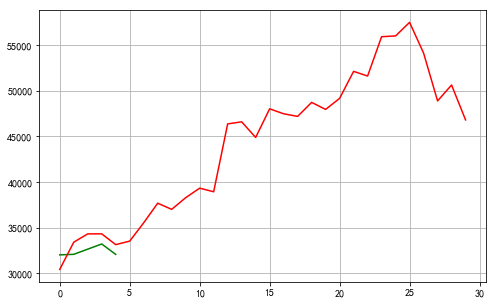

In [2276]:
fig = plt.figure(figsize=(8, 5))
axs1 = fig.add_subplot(111)
axs1.plot(pre_price, c='g')
axs1.plot(re_price,c='r')
plt.grid()
plt.show()

几何布朗运动

In [28]:
import numpy.random as npr

In [29]:
# 几何布朗运动预测
# 比特币 分年
bt_R=np.log(bchain.iloc[:,1]/bchain.iloc[:,1].shift(1)).dropna()
bt = np.array_split(bt_R.values, 5)
bt_miu = []
bt_sigma = []
for i in range(5):
    bt_miu.append(np.mean(bt[i])*365)
for i in range(5):
    bt_sigma.append(np.std(bt[i])*np.sqrt(365))
# bt_miu = 
# R=np.log(bchain.iloc[:,1]/bchain.iloc[:,1].shift(1))
# R=R.dropna()
# miu=R.mean()*365
# sigma=R.std()*np.sqrt(365)

In [30]:
bt_miu

[1.9218475197408762,
 0.39349599388653533,
 0.47267193080138437,
 0.01247503740492073,
 1.511512010729406]

In [31]:
bt_sigma

[0.7320618519253044,
 0.9459906073309821,
 0.6886334068166499,
 0.8175074637030038,
 0.7871302459566767]

In [32]:
# 黄金
lb_R=np.log(lbma.iloc[:,1]/lbma.iloc[:,1].shift(1)).dropna()
lb = np.array_split(lb_R.values, 5)
lb_miu = []
lb_sigma = []
for i in range(5):
    lb_miu.append(np.mean(lb[i])*251)
for i in range(5):
    lb_sigma.append(np.std(lb[i])*np.sqrt(251))
# R=np.log(lbma.iloc[:,1]/lbma.iloc[:,1].shift(1))
# R=R.dropna()
# miu=R.mean()*251
# sigma=R.std()*np.sqrt(251)

In [33]:
lb_miu

[0.0014333675269144058,
 -0.1038957431680112,
 0.23689929202203086,
 0.2509477061128427,
 -0.08203984565542113]

In [34]:
lb_sigma

[0.12550661445850977,
 0.08676070396633909,
 0.11134079013706354,
 0.18638330131091457,
 0.15554074889946934]

In [35]:
bc_date=pd.DatetimeIndex(start='2016-9-11',end='2021-9-9',freq='D')

In [36]:
bt_miu

[1.9218475197408762,
 0.39349599388653533,
 0.47267193080138437,
 0.01247503740492073,
 1.511512010729406]

In [37]:
bc_date=pd.DatetimeIndex(start='2016-9-11',end='2021-9-9',freq='D')
n=len(bc_date);I=25 #生成需要预测的维度，n天100次
bc_dt=1/356         #St和St-1之间的时间间隔
bc_result=np.zeros((n,I))
bc_result[0]=621.65
#datareader可找到2020年1月2日的股价，作为S0
y=0
for t in range(1,int(n/5)):
    e=npr.standard_normal(I)#生成100个服从正态分布的ε
    bc_result[t]=bc_result[t-1]*np.exp((bt_miu[y]-0.5*bt_sigma[y]**2)*bc_dt+bt_sigma[y]*e*np.sqrt(bc_dt))
y=1
for t in range(365,365*2):
     e=npr.standard_normal(I)#生成100个服从正态分布的ε
     bc_result[t]=bc_result[t-1]*np.exp((bt_miu[y]-0.5*bt_sigma[y]**2)*bc_dt+bt_sigma[y]*e*np.sqrt(bc_dt))
y=2
for t in range(365*2,365*3):
     e=npr.standard_normal(I)#生成100个服从正态分布的ε
     bc_result[t]=bc_result[t-1]*np.exp((bt_miu[y]-0.5*bt_sigma[y]**2)*bc_dt+bt_sigma[y]*e*np.sqrt(bc_dt))
y=3
for t in range(365*3,365*4):
     e=npr.standard_normal(I)#生成100个服从正态分布的ε
     bc_result[t]=bc_result[t-1]*np.exp((bt_miu[y]-0.5*bt_sigma[y]**2)*bc_dt+bt_sigma[y]*e*np.sqrt(bc_dt))
y=4
for t in range(365*4,365*5):
     e=npr.standard_normal(I)#生成100个服从正态分布的ε
     bc_result[t]=bc_result[t-1]*np.exp((bt_miu[y]-0.5*bt_sigma[y]**2)*bc_dt+bt_sigma[y]*e*np.sqrt(bc_dt))
bc_result=pd.DataFrame(bc_result,index=bc_date)

In [38]:
bc_co = []
for i in range(len(bc_result.columns)):
    if bc_result.iloc[-1,i]<100000 and bc_result.iloc[-1,i]>40000:
        bc_co.append(i) 

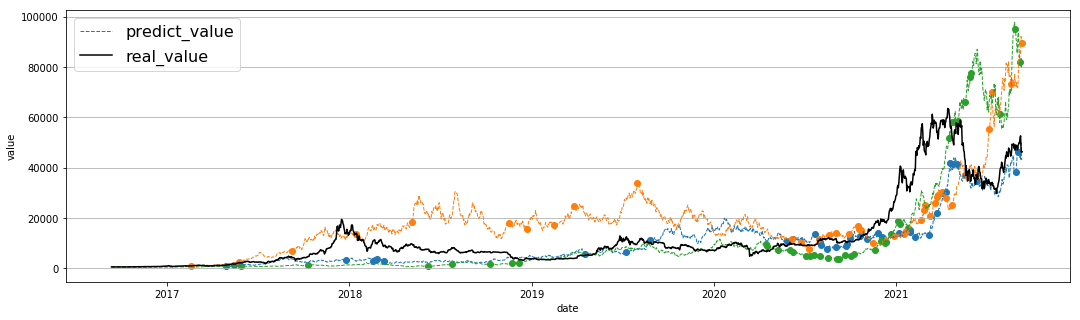

In [61]:
# import matplotlib.pyplot as plt
# from pylab import mpl
# mpl.rcParams['font.sans-serif']=['SimHei']
# mpl.rcParams['axes.unicode_minus']=False
fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(111)
ax1.plot(bc_result.iloc[:,bc_co[0]],lw=1 ,linestyle = '--',label='predict_value')
ax1.plot(bc_result.iloc[:,bc_co[1:]],lw=1 ,linestyle = '--')
ax1.plot(bchain.Date,bchain.iloc[:,1],c='black',lw=1.5,label = 'real_value')
for i in bc_co:
    bc_sample =  bc_result.iloc[1350:,i].sample(30).append(bc_result.iloc[:1500,i].sample(10))
    b = ax1.scatter(bc_sample.index,bc_sample.values)

ax1.set_xlabel('date',fontsize = 10)
ax1.set_ylabel('value',fontsize = 10)
# plt.xticks(rotation=30)#调整横坐标刻度值的角度
ax1.legend(fontsize=16)
plt.grid(axis='y')
plt.savefig('bc_bulang.svg')

In [43]:
lb_date=pd.DatetimeIndex(start='2016-9-11',end='2021-9-10',freq='B')
n=len(lb_date);I=4 #生成需要预测的维度，n天100次
lb_dt=1/251         #St和St-1之间的时间间隔
lb_result=np.zeros((n,I))
lb_result[0]=1324
#datareader可找到2020年1月2日的股价，作为S0
y=0
for t in range(1,261):
    e=npr.standard_normal(I)#生成100个服从正态分布的ε
    lb_result[t]=lb_result[t-1]*np.exp((lb_miu[y]-0.5*lb_sigma[y]**2)*lb_dt+lb_sigma[y]*e*np.sqrt(lb_dt))
y=1
for t in range(261,261*2):
    e=npr.standard_normal(I)#生成100个服从正态分布的ε
    lb_result[t]=lb_result[t-1]*np.exp((lb_miu[y]-0.5*lb_sigma[y]**2)*lb_dt+lb_sigma[y]*e*np.sqrt(lb_dt))
y=2
for t in range(261*2,261*3):
    e=npr.standard_normal(I)#生成100个服从正态分布的ε
    lb_result[t]=lb_result[t-1]*np.exp((lb_miu[y]-0.5*lb_sigma[y]**2)*lb_dt+lb_sigma[y]*e*np.sqrt(lb_dt))
y=3
for t in range(261*3,261*4):
    e=npr.standard_normal(I)#生成100个服从正态分布的ε
    lb_result[t]=lb_result[t-1]*np.exp((lb_miu[y]-0.5*lb_sigma[y]**2)*lb_dt+lb_sigma[y]*e*np.sqrt(lb_dt))
y=4
for t in range(261*4,261*5):
    e=npr.standard_normal(I)#生成100个服从正态分布的ε
    lb_result[t]=lb_result[t-1]*np.exp((lb_miu[y]-0.5*lb_sigma[y]**2)*lb_dt+lb_sigma[y]*e*np.sqrt(lb_dt))
lb_result=pd.DataFrame(lb_result,index=lb_date)

In [44]:
lb_co = []
for i in range(len(lb_result.columns)):
    if lb_result.iloc[-1,i]<10000 and lb_result.iloc[-1,i]>1000:
        lb_co.append(i)

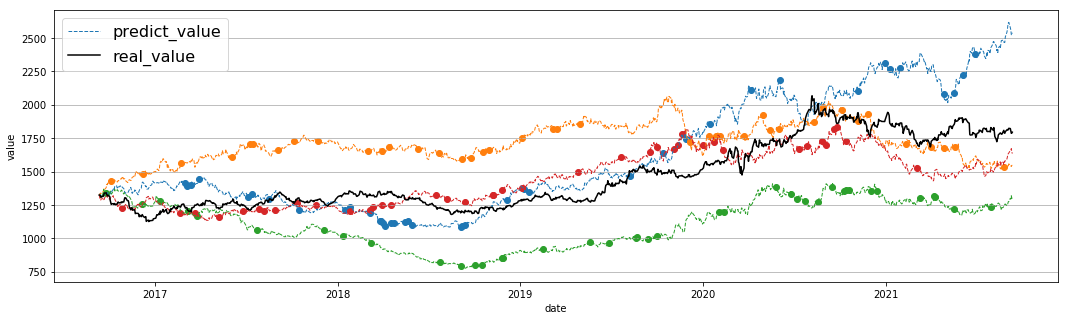

In [64]:
fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(111)
ax1.plot(lb_result.iloc[:,lb_co[0]],lw=1,linestyle = '--',label = 'predict_value')
ax1.plot(lb_result.iloc[:,lb_co[1:]],lw=1,linestyle = '--')

ax1.plot(lbma.Date,lbma.iloc[:,1],c='black',lw=1.5,label = 'real_value')
for i in lb_co:
    lb_sample =  lb_result.iloc[:,i].sample(40)
    ax1.scatter(lb_sample.index,lb_sample.values)
ax1.set_xlabel('date',fontsize=10)
ax1.set_ylabel('value',fontsize=10)
# plt.xticks(rotation=30)#调整横坐标刻度值的角度
plt.legend(fontsize=16)
plt.grid(axis='y')
plt.savefig('lb_bulang.svg')

In [ ]:
bc_result[bc_result.iloc[:,-1]<100000]

In [1795]:
bc_co = []
for i in range(len(bc_result.columns)):
    if bc_result.iloc[-1,i]<100000:
        bc_co.append(i)

In [89]:
plt.plot()

[4, 5, 15]

In [240]:
# make_up 3500 中值
from scipy import stats
exam = stats.norm.rvs(3500,3000,size=500)

E:\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


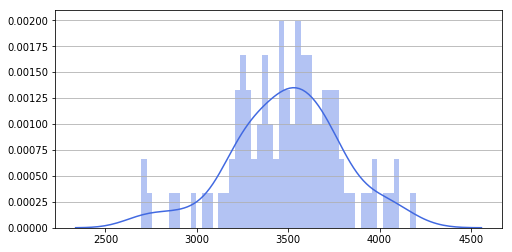

In [102]:
fig, ax1 = plt.subplots(figsize=(8,4))
# sns.distplot(returns, norm_hist=True, fit=stats.norm, color='blue',
#              bins=50, ax=ax1)
# ax1.set_title('Returns')
sns.distplot(exam, color='royalblue',
             bins=50)
# ax1.set_xlim(left=-0.15,right=0.15)
plt.grid(axis='y')
# fig.savefig('Norm.svg',bbox_inches="tight")

In [242]:
exam.max()

12196.044714708833

In [243]:
exam.min()

-7140.902591245338

In [244]:
exam.std()

3052.910628125048

In [252]:
exam[(exam>3900) & (exam<4200)].shape

(25,)

In [118]:
52+38

90

In [120]:
1250**5

3051757812500000

In [123]:
pow(4.3,0.2)

1.3387321435503967

In [ ]:
fig = plt.figure()

axs1 = fig.add_subplot(111)
for i in range(len(choose)):
    axs1.bar(df.columns, df.iloc[i,:], width=0.4, label=choose[i] ,bottom = df.iloc[:i,:].sum())
axs1.legend(loc=8,  shadow=True) 
axs1.legend(bbox_to_anchor=(1, 0), loc=3, borderaxespad=3)
axs1.grid()
axs1.set_title('Energy profile in four states in 2009',fontsize=20)
axs1.set_ylabel('million Btu')
# axs1.bar(index,df)
# axs[0].bar(index, salary2, width=0.4, bottom=salary1, label= 'salary2')
# axs[0].bar(index, salary3, width=0.4, bottom=salary2+salary1, label= 'salary3')
# axs[0].set_ylim(0, 30000)
# axs[0].set_xticklabels(name, rotation=90)
# axs[0].legend(loc='upper left',  shadow=True)
plt.savefig('2009各州.svg',format='svg',bbox_inches='tight')

In [ ]:
 bc_result.iloc[1350:,i].sample(30).append(bc_result.iloc[:1500,i].sample(10))

In [135]:
fig = plt.figure(figsize=(18, 4))
axs = fig.add_subplot(121)
axs[0].plot(lb_result.iloc[:,lb_co[0]],lw=1,linestyle = '--',label = 'predict_value')
axs[0].plot(lb_result.iloc[:,lb_co[1:]],lw=1,linestyle = '--')

ax1.plot(lbma.Date,lbma.iloc[:,1],c='black',lw=1.5,label = 'real_value')
    lb_sample =  lb_result.iloc[:,i].sample(40)
    ax1.scatter(lb_sample.index,lb_sample.values)
ax1.set_xlabel('date',fontsize=10)
ax1.set_ylabel('value',fontsize=10)
# plt.xticks(rotation=30)#调整横坐标刻度值的角度
plt.legend(fontsize=16)
plt.grid(axis='y')
plt.savefig('lb_bulang.svg')

IndentationError: unexpected indent (<ipython-input-135-697142908913>, line 7)

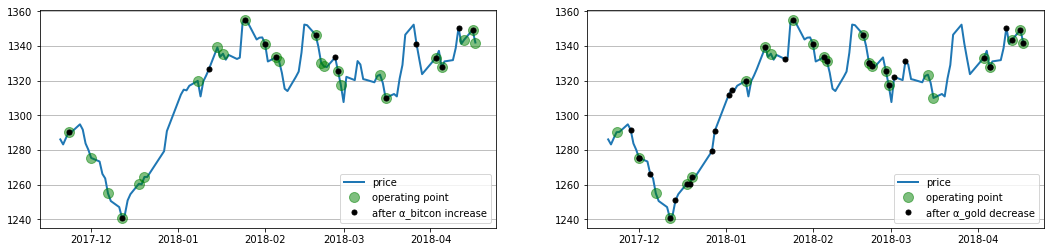

In [225]:
fig,axs=plt.subplots(1,2)
fig.set_size_inches(18,4)
axs[0].plot(lbma.iloc[300:400,0],lbma.iloc[300:400,1],lw=2,linestyle = '-',label = 'price')
# axs[0].plot_date(lbmas.iloc[:,0],lbmas.iloc[:,1],
#                  fmt='o',
#                 color = 'r',
#                 ms = 7,
#                 label = 'all_Decision_points'
#                 )
axs[0].plot_date(lbmas.iloc[:,0],lbmas.iloc[:,1],
                 fmt='o',
                color = 'g',
                ms = 10,
                alpha = 0.5,
                label = 'operating point'
                )
axs[0].plot_date(lbmass.iloc[:,0],lbmass.iloc[:,1].values,
                 fmt='o',
                color = 'black',
                ms = 5,
                )
axs[0].plot_date(lbmasss.iloc[:,0],lbmasss.iloc[:,1],
                 fmt='o',
                color = 'black',
                ms = 5,
                label = 'after '+chr(945)+'_bitcon increase'
                )

axs[0].grid(axis='y')

axs[1].plot(lbma.iloc[300:400,0],lbma.iloc[300:400,1],lw=2,linestyle = '-',label = 'price')
axs[1].plot_date(lbmas.iloc[:,0],lbmas.iloc[:,1],
                 fmt='o',
                color = 'g',
                ms = 10,
                alpha = 0.5,
                label = 'operating point'
                )
axs[1].plot_date(lb.iloc[:,0],lb.iloc[:,1],
                 fmt='o',
                color = 'black',
                ms = 5,
                label = 'after '+chr(945)+'_gold decrease'
                )
axs[1].plot_date(l.iloc[:,0],l.iloc[:,1].values,
                 fmt='o',
                color = 'black',
                ms = 5,
#               label = 'after '+chr(945)+' decrease'
                label = None
                )
axs[1].grid(axis='y')
axs[1].legend()
axs[0].legend()
# axs[0].yticks(rotation=90)#调整横坐标刻度值的角度
# axs[1].yticks(rotation=90)
# axs[0].plot(lb_result.iloc[:,lb_co[1:]],lw=1,linestyle = '--')
plt.savefig('sensitivity.svg')

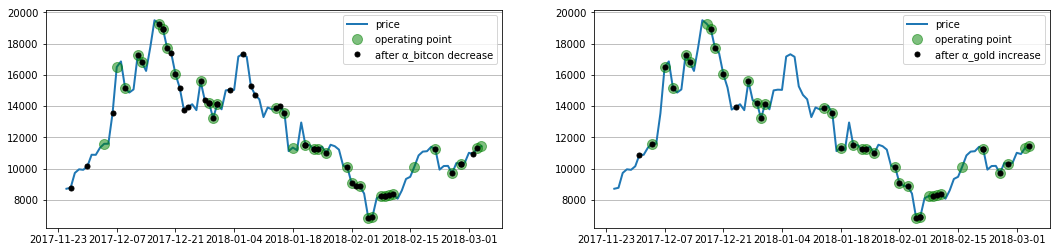

In [235]:
fig,axs=plt.subplots(1,2)
fig.set_size_inches(18,4)
axs[0].plot(bchain.iloc[440:540,0],bchain.iloc[440:540,1],lw=2,linestyle = '-',label = 'price')
# axs[0].plot_date(lbmas.iloc[:,0],lbmas.iloc[:,1],
#                  fmt='o',
#                 color = 'r',
#                 ms = 7,
#                 label = 'all_Decision_points'
#                 )
axs[0].plot_date(bc.iloc[:,0],bc.iloc[:,1],
                 fmt='o',
                color = 'g',
                ms = 10,
                alpha = 0.5,
                label = 'operating point'
                )
axs[0].plot_date(bcc.iloc[:,0],bcc.iloc[:,1].values,
                 fmt='o',
                color = 'black',
                ms = 5,
                )
axs[0].plot_date(bccc.iloc[:,0],bccc.iloc[:,1],
                 fmt='o',
                color = 'black',
                ms = 5,
                label = 'after '+chr(945)+'_bitcon decrease'
                )

axs[0].grid(axis='y')

axs[1].plot(bchain.iloc[440:540,0],bchain.iloc[440:540,1],lw=2,linestyle = '-',label = 'price')
axs[1].plot_date(bc.iloc[:,0],bc.iloc[:,1],
                 fmt='o',
                color = 'g',
                ms = 10,
                alpha = 0.5,
                label = 'operating point'
                )
axs[1].plot_date(bgold.iloc[:,0],bgold.iloc[:,1],
                 fmt='o',
                color = 'black',
                ms = 5,
                label = 'after '+chr(945)+'_gold increase'
                )
axs[1].plot_date(bgold_new.iloc[:,0],bgold_new.iloc[:,1].values,
                 fmt='o',
                color = 'black',
                ms = 5,
#               label = 'after '+chr(945)+' decrease'
                label = None
                )
axs[1].grid(axis='y')
axs[1].legend()
axs[0].legend()
# axs[0].yticks(rotation=90)#调整横坐标刻度值的角度
# axs[1].yticks(rotation=90)
# axs[0].plot(lb_result.iloc[:,lb_co[1:]],lw=1,linestyle = '--')
plt.savefig('bersensitivity.svg')

In [233]:
bc

,Date,Value
534,2018-02-27,10319.460000
510,2018-02-03,8852.730000
523,2018-02-16,10127.161670
464,2017-12-19,17737.111670
513,2018-02-06,6925.460000
494,2018-01-18,11345.423330
492,2018-01-16,13554.140000
490,2018-01-14,13852.920000
472,2017-12-27,15589.321670
502,2018-01-26,10969.815000


In [229]:
bc = bchain.iloc[440:540,:].sample(35)
bcc = bc.sample(27)
bccc = bchain.iloc[440:540,:].sample(25)
bgold = bc.sample(30)
bgold_new = bchain.iloc[440:540,:].sample(5)

In [147]:
lbsam = lbma.iloc[300:400,:].sample(25)

In [218]:
lbmas = lbma.iloc[300:400,:].sample(25)
lbmass = lbmas.sample(10)
lbmasss = lbma.iloc[300:400,:].sample(5)

In [219]:
lb = lbmas.sample(20)
l = lbma.iloc[300:400,:].sample(15)

In [237]:
np.array([3701,3777,3542,3608,3770,3845]).std()

104.06314856321083

In [239]:
pow(3000,0.5)

54.772255750516614